# Actividad - Proyecto práctico


> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Recordad que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
*   Alumno 1:
*   Alumno 2:
*   Alumno 3:
*   Alumno 4:
*   Manel González Huete






---
## **PARTE 1** - Instalación y requisitos previos

> Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la renderización en gym. Por ello, para obtener estas visualizaciones, se deberá trasladar el entorno de trabajo a local. Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. Siga los siguientes pasos para un correcto funcionamiento:
1.   **LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección *1.1.Preparar enviroment*.
2.  **AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
3. **COLAB:** se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo en Drive. Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
4.  **AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías necesarias*.


---
### 1.1. Preparar enviroment (solo local)



> Para preparar el entorno de trabajo en local, se han seguido los siguientes pasos:
1. En Windows, puede ser necesario instalar las C++ Build Tools. Para ello, siga los siguientes pasos: https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30.
2. Instalar Anaconda
3. Siguiendo el código que se presenta comentado en la próxima celda: Crear un enviroment, cambiar la ruta de trabajo, e instalar librerías básicas.


```
conda create --name miar_rl python=3.8
conda activate miar_rl
cd "PATH_TO_FOLDER"
conda install git
pip install jupyter
```


4. Abrir la notebook con *jupyter-notebook*.



```
jupyter-notebook
```


---
### 1.2. Localizar entorno de trabajo: Google colab o local

In [26]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount='/content/gdrive'
drive_root = mount + "/My Drive/08_MIAR/actividades/proyecto practico"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

---
### 1.3. Montar carpeta de datos local (solo Colab)

In [27]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

Archivos en el directorio: 
['.anaconda', '.conda', '.condarc', '.config', '.continuum', '.dia', '.gitconfig', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.Ld9VirtualBox', '.lesshst', '.matplotlib', '.virtual_documents', '.vscode', '01MAIR_ACT_Video.ipynb', '01MIAR_00_Intro.ipynb', '01MIAR_01_Python101.ipynb', '01MIAR_02_Python101_DataTypes.ipynb', '01MIAR_03_Python101_Control.ipynb', '01MIAR_04_Python101_Functions.ipynb', '01MIAR_05_Python101_Files.ipynb', '01MIAR_06_Python101_OOP.ipynb', '01MIAR_07_Python101_Advanced.ipynb', '01MIAR_08_NumPy.ipynb', '01MIAR_09_Pandas.ipynb', '01MIAR_10_+Pandas.ipynb', '01MIAR_11_Visualization.ipynb', '01MIAR_12_Data_Processing.ipynb', '01MIAR_13_Generators.ipynb', '01MIAR_14_Natural_Language.ipynb', '01MIAR_15_OCR.ipynb', '01MIAR_16_Image_Analysis.ipynb', '01MIAR_ACT_Actividad_Final.ipynb', '01MIAR_ACT_Final.ipynb', '01MIAR_ACT_Group.ipynb', '01MIAR_ACT_Group_Solved.ipynb', '01MIAR_ACT_WhitePapers_Canarias.ipynb', '01MIAR_ACT_WhitePapers

---
### 1.4. Instalar librerías necesarias

In [ ]:
if IN_COLAB:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install keras-rl2==1.0.5
  %pip install tensorflow==2.8
else:
  %pip install numpy==1.23.5
  %pip install gym==0.17
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install pyglet==1.5.0
  %pip install h5py==3.1.0
  %pip install Pillow==9.5.0
  %pip install keras-rl2==1.0.5
  %pip install Keras==2.2.4
  %pip install tensorflow==2.5.3
  %pip install torch==2.0.1
  %pip install agents==1.4.0
  %pip install matplotlib==3.4.3
  %pip install tqdm

---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, el requisito mínimo será alcanzado cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

---
## **PARTE 3**. Desarrollo y preguntas

### Importar librerías

In [28]:
from __future__ import division

from PIL import Image
import numpy as np
import gym
import matplotlib.pyplot as plt
import tensorflow as tf
import gc

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Convolution2D, Permute
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
from collections import deque
from tqdm import trange
import tensorflow.keras.backend as K

### Crear el entorno
Nuestro entorno es el juego Space Invaders, de Atari

In [29]:
# Create our environment
env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [30]:
print("El tamaño de nuestro 'frame' es: ", env.observation_space)
print("El número de acciones posibles es : ", nb_actions)
print("Las acciones posibles son : ",env.env.get_action_meanings())

# Here we create an hot encoded version of our actions
# possible_actions = [[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0]...]
possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())
print("\nOHE de las acciones posibles: \n", possible_actions)

El tamaño de nuestro 'frame' es:  Box(210, 160, 3)
El número de acciones posibles es :  6
Las acciones posibles son :  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

OHE de las acciones posibles: 
 [[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


### Definición Hiperparámetros

In [31]:
### HIPERPARÁMETROS DEL MODELO
INPUT_SHAPE = (84, 84)
state_size = [84, 84, 4]          # Nuestra entrada es una pila de 4 fotogramas, por lo tanto 110x84x4 (ancho, alto, canales)
action_size = env.action_space.n  # 6 acciones posibles
learning_rate =  0.00025          # Alfa (también conocido como tasa de aprendizaje)

### HIPERPARÁMETROS DE ENTRENAMIENTO
# total_episodios = 50           # Episodios totales para el entrenamiento
# max_steps = 50000              # Máximo de pasos posibles por episodio
total_episodios = 10           # Episodios totales para el entrenamiento
max_steps = 10000              # Máximo de pasos posibles por episodio
batch_size = 32                # Tamaño del lote (batch)

# Parámetros de exploración para la estrategia epsilon-greedy
epsilon_start = 1.0            # Probabilidad de exploración al inicio
epsilon_stop = 0.01            # Probabilidad mínima de exploración
decay_rate = 0.00001           # Tasa de decaimiento exponencial para la probabilidad de exploración
epsilon_decay = 0.995

# Hiperparámetros del aprendizaje Q
gamma = 0.95                   # Tasa de descuento

### HIPERPARÁMETROS DE MEMORIA
pretrain_length = batch_size   # Número de experiencias almacenadas en la memoria al inicializar por primera vez
memory_size = 20000            # Número de experiencias que la memoria puede guardar
memory = deque(maxlen=20000)

### HIPERPARÁMETROS DE PREPROCESAMIENTO
WINDOW_LENGTH = 4              # Número de fotogramas apilados

### CAMBIA ESTO A FALSE SI SOLO QUIERES VER AL AGENTE ENTRENADO
training = False

## CAMBIA ESTO A TRUE SI QUIERES RENDERIZAR EL ENTORNO
episode_render = False

### Clase "processor" para Atari

Ahora definimos un "processor" para las pantallas de entrada del juego, en el que recortamos el tamaño de la imagen (matriz de 210 x 160 píxeles) y la convertimos En una matriz bidimensional de 80 x 80 píxeles). También convertimos las imágenes de RGB a escala de grises normal, ya que no necesitamos usar los colores. Con este trabajo buscamos acelerar nuestro algoritmo, eliminando la información innecesaria y reduciendo la carga de la GPU.

In [32]:
from rl.core import Processor

class AtariProcessor(Processor):
    def process_observation(self, observation):
        """
        Preprocesamiento simple: convierte a escala de grises y normaliza
        """
        assert observation.ndim == 3  # (height, width, channel)
        img = Image.fromarray(observation)
        img = img.resize(INPUT_SHAPE).convert('L')
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')

    def process_state_batch(self, batch):
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

### Revisar el entorno de juego

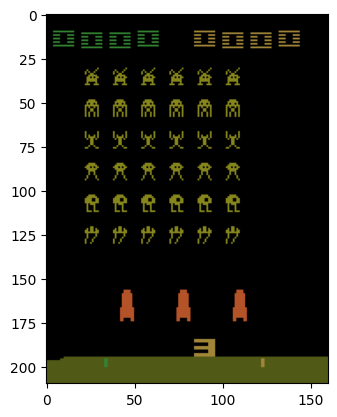

In [33]:
import matplotlib.pyplot as plt

observation = env.reset()
for i in range(22): 
  if i > 20:
    plt.imshow(observation)
    plt.show()

  observation, _, _, _ = env.step(1)

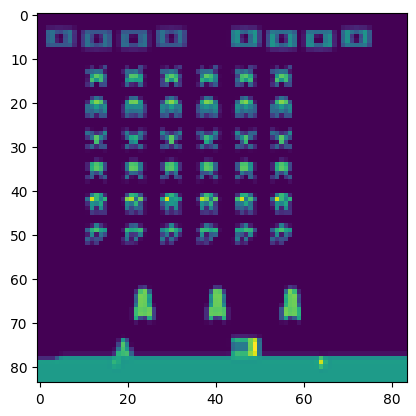

(210, 160, 3)
(84, 84)


In [34]:
# Mostrar las entradas preprocesadas en escala de grises y comparar originales y preprocesados.
processor = AtariProcessor()
obs_preprocessed = processor.process_observation(observation).reshape(INPUT_SHAPE)
plt.imshow(processor.process_state_batch(obs_preprocessed))
plt.show()
print(observation.shape)
print(obs_preprocessed.shape)

1. Implementación de la red neuronal

Crearemos una clase para construir un red Q-profunda, con tres capas convolucionales, seguidas de una capa de aplanamiento y una capa completamente conectada.

In [87]:
class DQNetwork(tf.keras.Model):
    """
    Red neuronal Deep Q-Network (DQN) para aproximar la función Q en aprendizaje por refuerzo.

    Esta clase implementa una red convolucional que recibe un estado (conjunto de frames)
    y produce los valores Q para cada acción posible. Usa capas convolucionales seguidas
    de capas totalmente conectadas, con activación ELU.

    Parámetros:
    -----------
    state_size : tupla/lista - Dimensiones del estado de entrada (por ejemplo, [84, 84, 4]).
    action_size : int        - Número de acciones posibles en el entorno.
    learning_rate : float    - Tasa de aprendizaje para el optimizador Adam.
    name : str, opcional     - Nombre del scope de TensorFlow para distinguir múltiples redes.
    """
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        super(DQNetwork, self).__init__(name=name)
        
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

        # Primera capa convolucional con activación ELU
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(8,8), strides=(4,4) ,
                                            padding='same', activation='elu',
                                            kernel_initializer='glorot_uniform')  # (84, 84, 4)
        # Segunda capa convolucional con activación ELU
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), strides=(2,2),
                                            padding='same', activation='elu',
                                            kernel_initializer='glorot_uniform')
        # Tercera capa convolucional con activación ELU
        self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1),
                                            padding='same', activation='elu',
                                            kernel_initializer='glorot_uniform')
        # Aplanar la salida de la última convolucional
        self.flatten = tf.keras.layers.Flatten()
        # Capa completamente conectada con activación ELU
        self.fc = tf.keras.layers.Dense(units=512, activation='elu',
                                        kernel_initializer='glorot_uniform')
        # Capa de salida que devuelve valores Q para cada acción
        self.output_layer = tf.keras.layers.Dense(units=self.action_size,
                                                  activation=None,
                                                  kernel_initializer='glorot_uniform')

        # Definir el optimizador
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Definir la función de pérdida (error cuadrático medio)
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def call(self, inputs):
        """
        Ejecuta la red neuronal para un batch de estados y define la lógica para hacer la propagación hacia adelante (forward pass). 
        Se llama automáticamente en una clase que hereda de tf.keras.Model o tf.keras.layers.Layer.

        Parámetros:
        -----------
        inputs : tf.Tensor  - Tensor con los estados de entrada, shape = (batch_size, *state_size)

        Retorna:
        --------
        tf.Tensor - Valores Q para cada acción, shape = (batch_size, action_size)
        """
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.fc(x)
        q_values = self.output_layer(x)
        return q_values


#    @tf.function
    def train_step(self, states, actions, target_q):
        """
        Realiza un paso de entrenamiento: calcula la pérdida y aplica gradientes.
        declaramos train_step con @tf.function para eficiencia

        Parámetros:
        -----------
        states : tf.Tensor -    Batch de estados de entrada, shape = (batch_size, *state_size)
        actions : tf.Tensor -   Acciones tomadas, codificadas one-hot, shape = (batch_size, action_size)
        target_q : tf.Tensor -  Valores objetivo Q, shape = (batch_size,)

        Retorna:
        --------
        loss : tf.Tensor -      Valor de la pérdida calculada en este paso.
        """
        with tf.GradientTape() as tape:
            q_values = self.call(states)  # Salida con valores Q para todas las acciones
            # Obtenemos Q para las acciones tomadas multiplicando por la máscara one-hot y sumando
            q_action = tf.reduce_sum(q_values * actions, axis=1)
            # Si target_q es (batch_size, num_actions), entonces:
            target_q_action = tf.reduce_sum(tf.expand_dims(target_q, axis=1) * actions, axis=1)            
            # Calculamos la pérdida MSE entre Q predicho y target_Q
            loss = self.loss_fn(target_q_action, q_action)

        # Calculamos los gradientes y actualizamos los pesos
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return loss

2. Implementación de la solución DQN

In [88]:
class FrameStack:
    """
    Clase para apilar frames consecutivos
    """
    def __init__(self, num_frames=4):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)
    
    def reset(self):
        self.frames.clear()
    
    def add_frame(self, frame):
        # Si es el primer frame, llenamos el deque
        if len(self.frames) == 0:
            for _ in range(self.num_frames):
                self.frames.append(frame)
        else:
            self.frames.append(frame)
    
    def get_state(self):
        # Convertir a array con shape (84, 84, 4)
        return np.stack(self.frames, axis=-1)

In [92]:
def simple_train(env,dqnet, processor, epsilon_start,total_episodios):
    """
    Entrenamiento simple con tu red DQN
    """
    print(f"[DEBUG] - Configuración:")
    print(f"  - State size: {state_size}")
    print(f"  - Action size: {action_size}")
    print(f"  - Learning rate: {learning_rate}")
    print(f"  - Gamma: {gamma}")
    print(f"  - TensorFlow eager: {tf.executing_eagerly()}")

    # Habilitar eager execution para poder usar .numpy()
    if not tf.executing_eagerly():
        tf.config.run_functions_eagerly(True)
        print("[INFO] - Eager execution habilitado")

    scores = []

    for episode in trange(total_episodios, desc="Training"):
        observation = env.reset()
        frame_stack = FrameStack(WINDOW_LENGTH)
        
        processed_frame = processor.process_observation(observation)
        frame_stack.add_frame(processed_frame)
        state = frame_stack.get_state()    
        # NO convertir a 1 canal - mantener los 4 canales del frame stack
        # Normalizar estado (el processor debería manejar el formato (84, 84, 4))
        state = processor.process_state_batch(np.expand_dims(state, 0))[0]
        
        total_reward = 0
        steps = 0
        max_steps = 1000
        
        while steps < max_steps:
            # Selección epsilon-greedy
            if np.random.random() <= epsilon_start:
                action = env.action_space.sample()
            else:
                # Método más robusto para obtener acción
                state_input = tf.convert_to_tensor(np.expand_dims(state, axis=0), dtype=tf.float32)
                q_values = dqnet(state_input)
                action = tf.argmax(q_values[0]).numpy()            
                
            # Ejecutar acción
            next_observation, reward, done, _ = env.step(action)
            
            # Procesar siguiente estado
            processed_next_frame = processor.process_observation(next_observation)
            frame_stack.add_frame(processed_next_frame)
            next_state = frame_stack.get_state()
            next_state = processor.process_state_batch(np.expand_dims(next_state, 0))[0] 
            
            # Procesar reward (clip entre -1 y 1)
            reward = processor.process_reward(reward)        

            # Calcular Q objetivo
            next_q_vals = dqnet(tf.expand_dims(next_state, 0), training=False)
            max_next_q = tf.reduce_max(next_q_vals[0])
            target_q_value = reward + gamma * max_next_q * (1.0 - float(done))

            # Preparar tensores para entrenamiento
            states_tf = tf.convert_to_tensor(np.expand_dims(state, 0), dtype=tf.float32)
            actions_onehot = tf.one_hot([action], action_size)  # shape (1, action_size)
            target_q_tensor = tf.convert_to_tensor([target_q_value], dtype=tf.float32)
            # Entrenamiento usando método interno
            loss = dqnet.train_step(states_tf, actions_onehot, target_q_tensor)

            # Actualizar estado
            state = next_state
            total_reward += reward
            steps += 1

            if steps % 100 == 0:
                if len(memory) > 32:
                    print(f"  [INFO] - Ep {episode:3d} Step {steps:3d}: Training active")
                else:
                    print(f"  [INFO] - Ep {episode:3d} Step {steps:3d}: Collecting data ({len(memory)}/32)")

            if done:
                break
 
        # Actualizar epsilon
        if epsilon_start > epsilon_stop:
            epsilon_start *= epsilon_decay
        
        scores.append(total_reward)
        avg_score = np.mean(scores[-10:]) if len(scores) >= 10 else np.mean(scores)
        
        print(f"\n📊 Episodio {episode + 1}/{total_episodios}")
        print(f"   Score: {total_reward:.1f} | Steps: {steps}")
        print(f"   Epsilon: {epsilon_start:.3f} | Avg Score: {avg_score:.2f}")
        print(f"   Memory size: {len(memory)}")
        print("-" * 40)

        # Guardar cada 10 episodios
        if (episode + 1) % 10 == 0:
            try:
                dqnet.save_weights(f'dqn_checkpoint_ep{episode + 1}.h5')
                print(f"💾 Guardado: {checkpoint_path}")
            except Exception as e:
                print(f"⚠️  Error guardando: {e}")    

        # Al final del bucle de episodios
        gc.collect()
        K.clear_session()

    env.close()    
    print("\n🎯 Entrenamiento completado!")
    return dqnet

In [93]:
def test_simple_dqn(dqn, episodes=3):
    """
    Probar la red entrenada
    """
    env = gym.make('SpaceInvaders-v0')
    
    for episode in range(episodes):
        state = env.reset()
        state = preprocess_state(state)
        total_reward = 0
        steps = 0
        
        while steps < 1000:
            env.render()
            
            # Sin exploración - solo usar la red
            state_tensor = tf.expand_dims(state, 0)
            q_values = dqn(state_tensor)
            action = np.argmax(q_values[0])
            
            next_state, reward, done, _ = env.step(action)
            state = preprocess_state(next_state)
            total_reward += reward
            steps += 1
            
            if done:
                break
        
        print(f"Episodio de prueba {episode + 1}: Score = {total_reward}, Steps = {steps}")
    
    env.close()

In [94]:
import random

if __name__ == "__main__":
    # Crear la red - FORZAR state_size a 4 canales para frame stacking
    print(f"[DEBUG] - Tamaño original del estado (state_size): {state_size}")  # DEBUG
    dqnet = DQNetwork(state_size, action_size, learning_rate)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.MeanSquaredError()    
    print(f"[DEBUG] - Red creada correctamente\n\n")  # DEBUG
    
    # Crear el procesador Atari
    processor = AtariProcessor()

    print("-" * 60)
    print("Entrenando DQN simple para Space Invaders...")
    print("Esto es una versión simplificada para pruebas rápidas")
    print("-" * 60)    
    # Entrenar
    trained_dqn = simple_train(env,dqnet, processor, epsilon_sta
                               rt,total_episodios)
    
    # Probar
    print("\nProbando DQN entrenada...")
    # test_simple_dqn(trained_dqn, episodes=2)

[DEBUG] - Tamaño original del estado (state_size): [84, 84, 4]
[DEBUG] - Red creada correctamente


------------------------------------------------------------
Entrenando DQN simple para Space Invaders...
Esto es una versión simplificada para pruebas rápidas
------------------------------------------------------------
[DEBUG] - Configuración:
  - State size: [84, 84, 4]
  - Action size: 6
  - Learning rate: 0.00025
  - Gamma: 0.95
  - TensorFlow eager: False
[INFO] - Eager execution habilitado


Training:   0%|          | 0/10 [00:00<?, ?it/s]

  [INFO] - Ep   0 Step 100: Training active
  [INFO] - Ep   0 Step 200: Training active
  [INFO] - Ep   0 Step 300: Training active
  [INFO] - Ep   0 Step 400: Training active
  [INFO] - Ep   0 Step 500: Training active
  [INFO] - Ep   0 Step 600: Training active
  [INFO] - Ep   0 Step 700: Training active

📊 Episodio 1/10
   Score: 10.0 | Steps: 755
   Epsilon: 0.995 | Avg Score: 10.00
   Memory size: 1341
----------------------------------------


Training:  10%|█         | 1/10 [00:54<08:08, 54.25s/it]


ValueError: in user code:

    C:\Users\ManelGH\AppData\Local\Temp\ipykernel_8948\3881738410.py:63 call  *
        x = self.conv1(inputs)
    C:\Users\ManelGH\.conda\envs\miar_rl\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:783 __call__  **
        outputs = call_fn(cast_inputs, *args, **kwargs)
    C:\Users\ManelGH\.conda\envs\miar_rl\lib\site-packages\tensorflow\python\keras\layers\convolutional.py:249 call
        outputs = self._convolution_op(inputs, self.kernel)
    C:\Users\ManelGH\.conda\envs\miar_rl\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\ManelGH\.conda\envs\miar_rl\lib\site-packages\tensorflow\python\ops\nn_ops.py:1012 convolution_v2
        return convolution_internal(
    C:\Users\ManelGH\.conda\envs\miar_rl\lib\site-packages\tensorflow\python\ops\nn_ops.py:1131 convolution_internal
        with ops.name_scope(name, default_name, [input, filters]) as name:
    C:\Users\ManelGH\.conda\envs\miar_rl\lib\site-packages\tensorflow\python\framework\ops.py:6530 __enter__
        g_from_inputs = _get_graph_from_inputs(self._values)
    C:\Users\ManelGH\.conda\envs\miar_rl\lib\site-packages\tensorflow\python\framework\ops.py:6165 _get_graph_from_inputs
        _assert_same_graph(original_graph_element, graph_element)
    C:\Users\ManelGH\.conda\envs\miar_rl\lib\site-packages\tensorflow\python\framework\ops.py:6098 _assert_same_graph
        raise ValueError(

    ValueError: Tensor("DQNetwork_1/conv2d/kernel/Read/ReadVariableOp:0", shape=(8, 8, 4, 32), dtype=float32) must be from the same graph as Tensor("ExpandDims:0", shape=(1, 84, 84, 4), dtype=float32) (graphs are <tensorflow.python.framework.ops.Graph object at 0x00000139F394CF70> and <tensorflow.python.framework.ops.Graph object at 0x0000013A69A09B80>).


3. Justificación de los parámetros seleccionados y de los resultados obtenidos

---